In [1]:
from google.colab import drive

drive.mount("/content/drive")
main_path = "drive/MyDrive/NolokonNotebooks/MnistFashionDiffusion"


Mounted at /content/drive


In [2]:
import os
import shutil


def recreate_dir(main_path: str) -> None:
    if not os.path.exists(main_path):
        os.makedirs(main_path)
        print(f"Folder {main_path} did not exist, so it was created.")
    else:
        kopia_path = f"{main_path}_kopia"
        shutil.copytree(main_path, kopia_path)
        shutil.rmtree(main_path)
        os.rename(kopia_path, main_path)
        print(f"Folder {main_path} has been replaced by its copy.")


# recreate_dir(f"{main_path}/model_paths")  # Run on host account


In [3]:
%pip install torch diffusers


In [4]:
import os
import re

from diffusers import DDPMScheduler, UNet2DModel
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torch.nn as nn
from tqdm import tqdm
import torch


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
learning_rate = 0.0004
batch_size = 64
image_size = 28
time_steps = 1_000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

class_labels = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")
draw_classes = (0, 2, 9)


cuda


In [6]:
train_set = datasets.FashionMNIST(
    f"{main_path}/data/",
    download=True,
    train=True,
    transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
    )


In [7]:
print("Train size:", len(train_loader)*batch_size)


Train size: 60032


In [8]:
test_set = datasets.FashionMNIST(
    f"{main_path}/data/",
    download=True,
    train=False,
    transform=transform
    )

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True
    )


In [9]:
print("Test size:", len(test_loader)*batch_size)


Test size: 10048


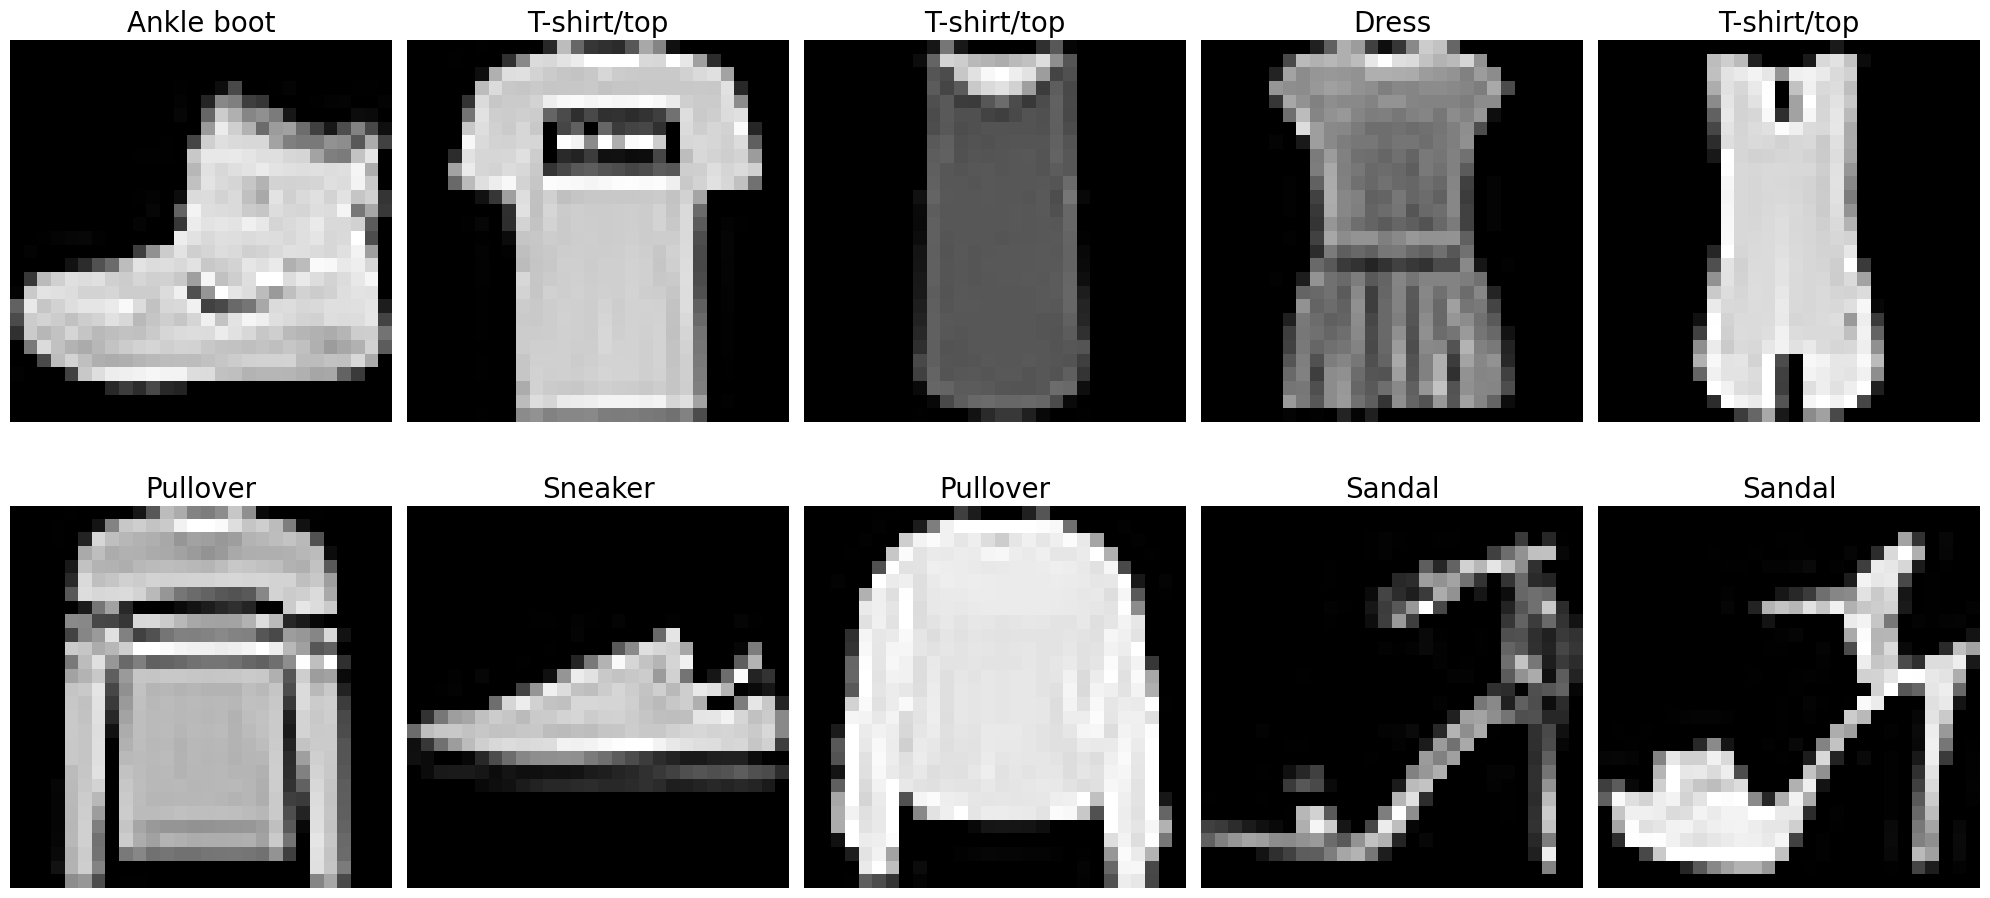

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    data, label = train_set[i]

    ax.imshow(data.squeeze(), cmap="gray")
    ax.set_title(class_labels[label], fontsize=20)

    ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
# DDPM i DDIM - różne funckje do generowania
# Co zwraca model?


In [12]:
def generate_image_with_class(model, scheduler, image_size, device, class_idx, num_inference_steps=1_000):
    scheduler.set_timesteps(num_inference_steps)

    noisy_image = torch.randn(1, 1, image_size, image_size).to(device)

    for t in reversed(range(scheduler.num_inference_steps)):
        t_tensor = torch.tensor([t], device=device).long()
        class_labels = torch.tensor([class_idx], device=device).long()

        with torch.no_grad():
            noise_pred = model(noisy_image, t_tensor, class_labels).sample

        noisy_image = scheduler.step(noise_pred, t_tensor, noisy_image).prev_sample

    generated_image = (noisy_image.clamp(-1, 1) + 1) / 2
    generated_image = generated_image.cpu().squeeze(0).squeeze(0)

    return generated_image


def show_images(images: list[Tensor]) -> None:
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap="gray")
        # plt.axis("off")
    plt.show()


def encode_class(labels: list[str], num_classes: int) -> Tensor:
    one_hot_labels = torch.zeros(len(labels), num_classes, device=labels.device)
    for i, label in enumerate(labels):
        one_hot_labels[i, label] = 1
    return one_hot_labels


def get_latest_epoch_folder(base_path: str) -> str:
    epoch_regex = re.compile(r"epoch_(\d+)")

    max_epoch = -1
    latest_epoch_folder = None

    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        if not os.path.isdir(folder_path):
            the_match = epoch_regex.search(folder_name)
            if the_match:
                epoch = int(the_match.group(1))
                if epoch > max_epoch:
                    max_epoch = epoch
                    latest_epoch_folder = folder_path

    return latest_epoch_folder


In [13]:
class ClassConditionedUNet2DModel(UNet2DModel):
    def __init__(self, class_emb_dim: int = 10, num_classes: int = 10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_emb = nn.Embedding(num_classes, class_emb_dim)

    def forward(self, x, timesteps, class_labels):
        class_emb = self.class_emb(class_labels).unsqueeze(-1).unsqueeze(-1)
        class_emb = class_emb.repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat([x, class_emb], dim=1)
        return super().forward(x, timesteps)


model = ClassConditionedUNet2DModel(
    class_emb_dim=len(class_labels),
    num_classes=len(class_labels),
    sample_size=image_size,
    in_channels=1+len(class_labels),
    out_channels=1,
    layers_per_block=3,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

scheduler = DDPMScheduler(num_train_timesteps=time_steps)


start_epoch = 0
latest_path = get_latest_epoch_folder(f"{main_path}/model_paths")
print("Latest path:", latest_path)

if latest_path is not None:
    last_epoch = int(latest_path.split("_")[-1].split(".")[0])
    model.load_state_dict(torch.load(
        f"{latest_path}",
        map_location=device,
        weights_only=True
        ))
    start_epoch = last_epoch + 1

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Latest path: drive/MyDrive/NolokonNotebooks/MnistFashionDiffusion/model_paths/epoch_92.pth


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 938/938 [03:01<00:00,  5.18it/s]


Epoch 93, Loss: 0.03239063639193773


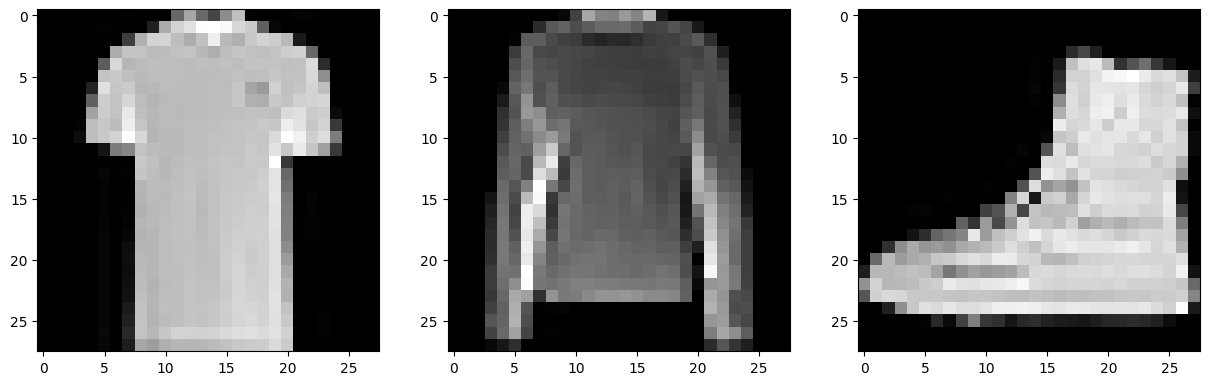

100%|██████████| 938/938 [03:01<00:00,  5.18it/s]


Epoch 94, Loss: 0.032868553256826485


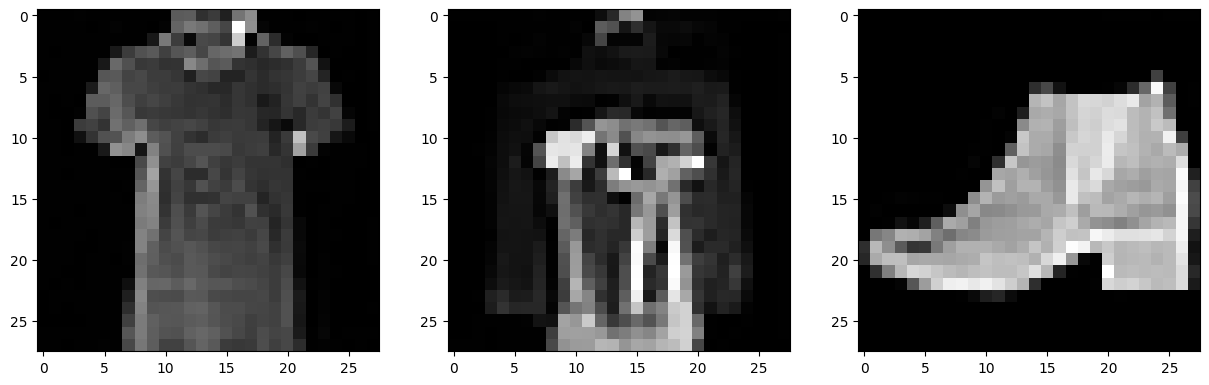

100%|██████████| 938/938 [03:01<00:00,  5.17it/s]


Epoch 95, Loss: 0.03236542642612987


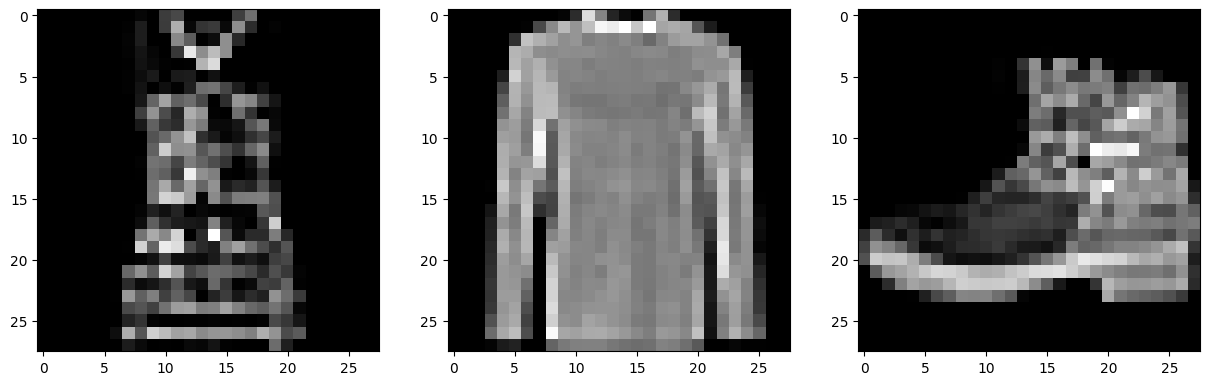

100%|██████████| 938/938 [03:01<00:00,  5.17it/s]


Epoch 96, Loss: 0.03228019519861954


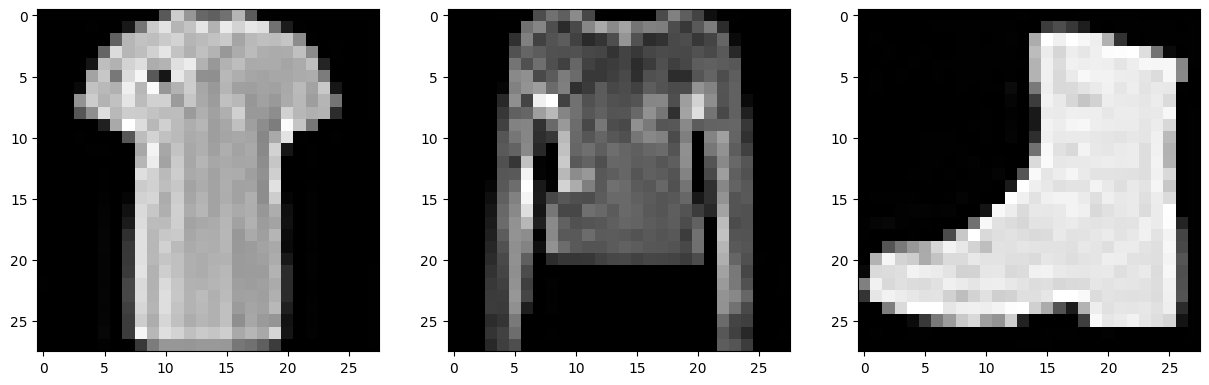

100%|██████████| 938/938 [03:01<00:00,  5.17it/s]


Epoch 97, Loss: 0.032097658934766675


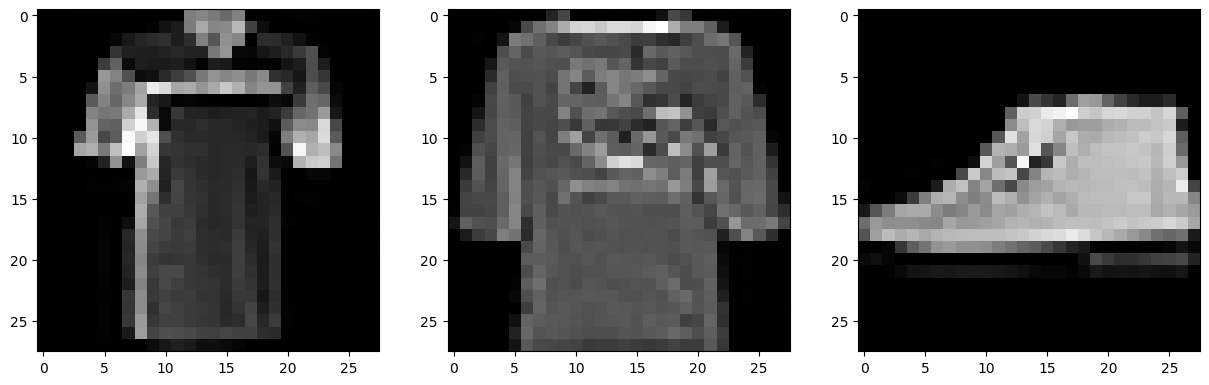

100%|██████████| 938/938 [03:01<00:00,  5.17it/s]


Epoch 98, Loss: 0.03266116892243785


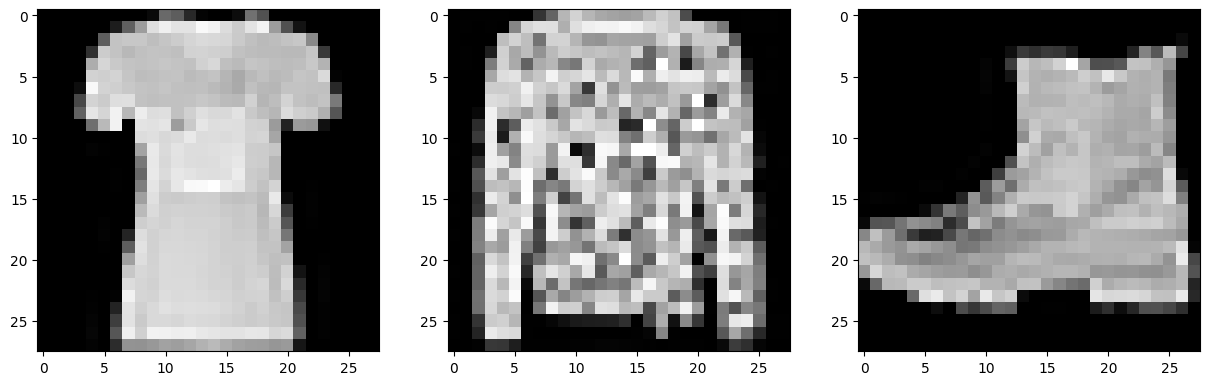

100%|██████████| 938/938 [03:01<00:00,  5.17it/s]


Epoch 99, Loss: 0.03215264386312762


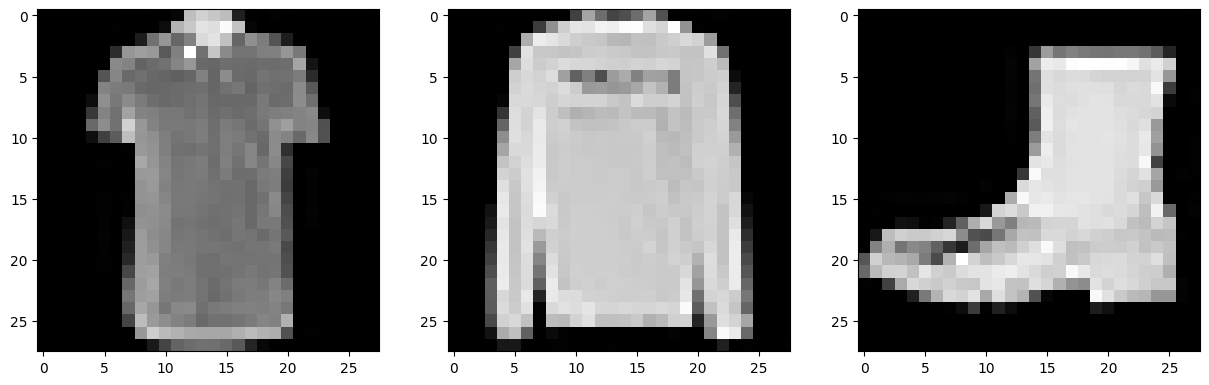

In [14]:
last_avg_loss = float("inf")
epochs = 20

losses = []
for epoch in range(start_epoch, last_epoch+epochs):
    if epoch >= 100:
      break

    model.train()
    tmp_loss_list = []

    for batch in tqdm(train_loader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        noise = torch.randn_like(inputs)
        timesteps = torch.randint(
            0,
            scheduler.num_train_timesteps,
             (inputs.shape[0],),
            device=device
            ).long()

        noisy_inputs = scheduler.add_noise(inputs, noise, timesteps)

        noise_pred = model(noisy_inputs, timesteps, labels).sample
        loss = F.mse_loss(noise_pred, noise)
        tmp_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = sum(tmp_loss_list) / len(tmp_loss_list)
    torch.save(model.state_dict(), f"{main_path}/model_paths/epoch_{epoch}.pth")
    print(f"Epoch {epoch}, Loss: {avg_loss}")
    losses.append(avg_loss)

    model.eval()
    images = []
    for i in range(3):
        image = generate_image_with_class(model, scheduler, image_size, device, draw_classes[i], time_steps)
        images.append(image)
    show_images(images)


T-shirt/top


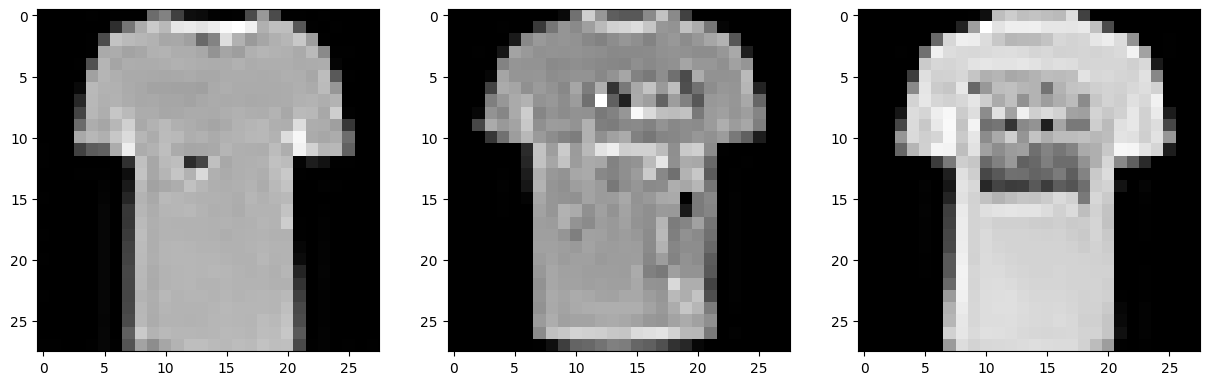

Trouser


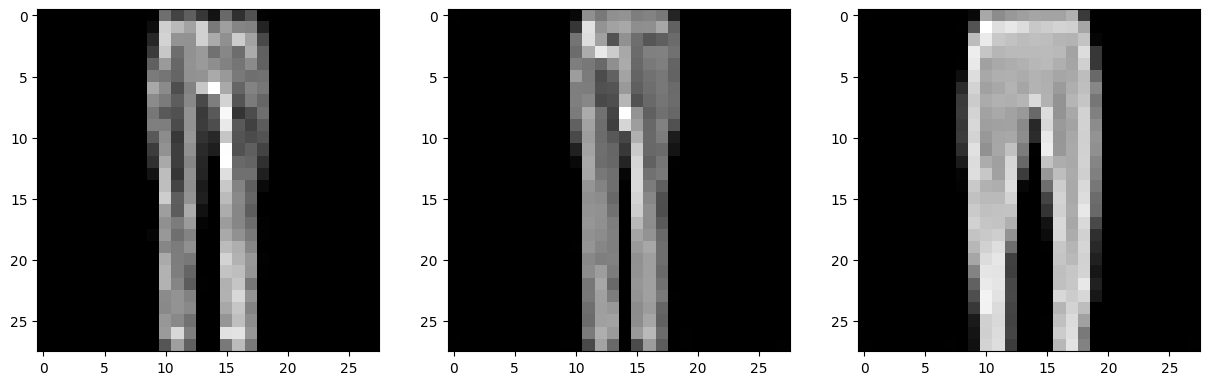

Pullover


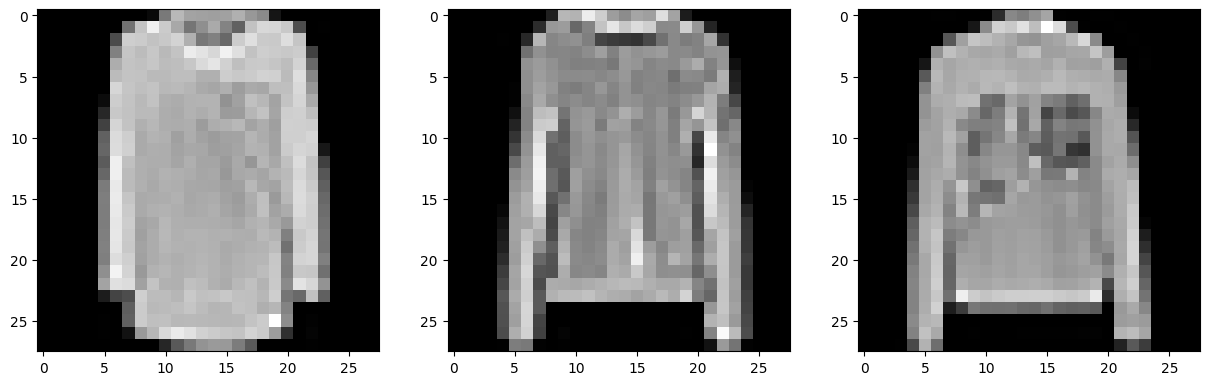

Dress


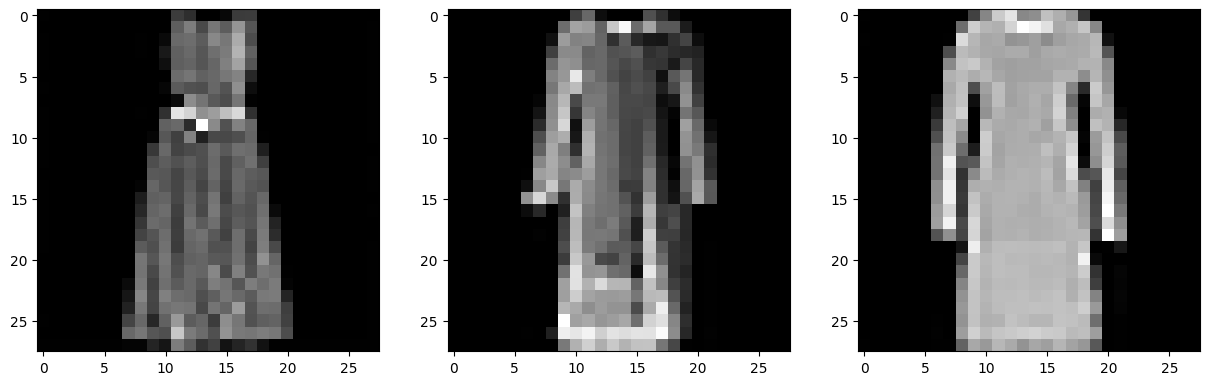

Coat


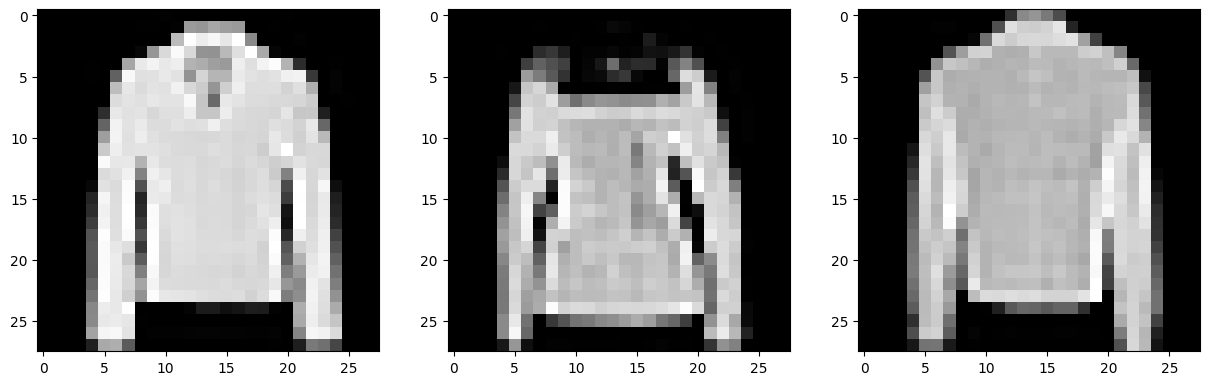

Sandal


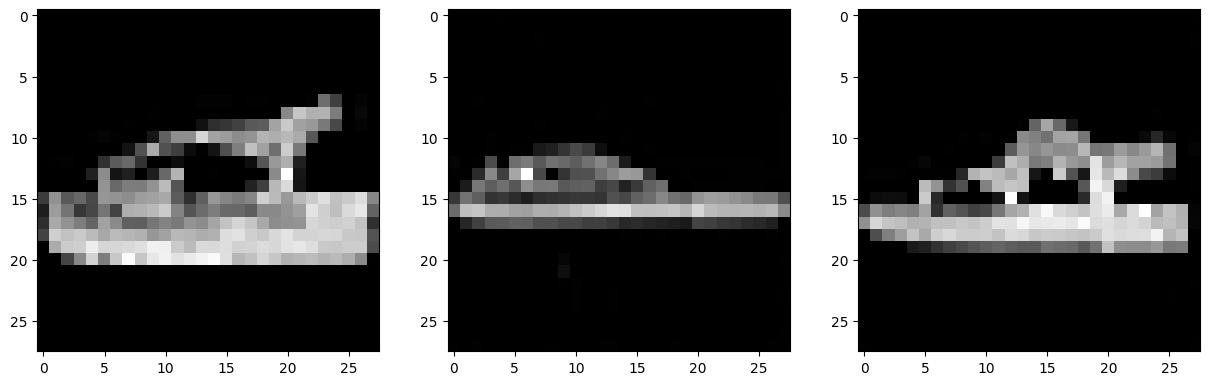

Shirt


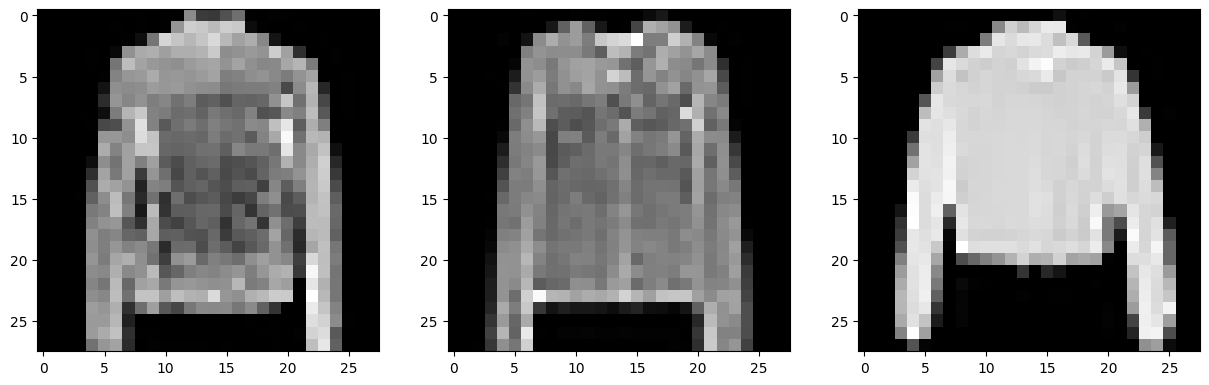

Sneaker


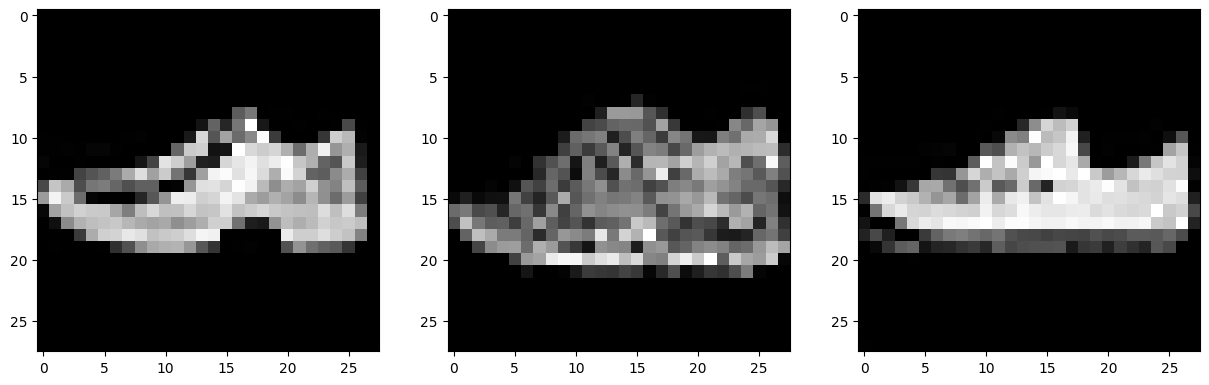

Bag


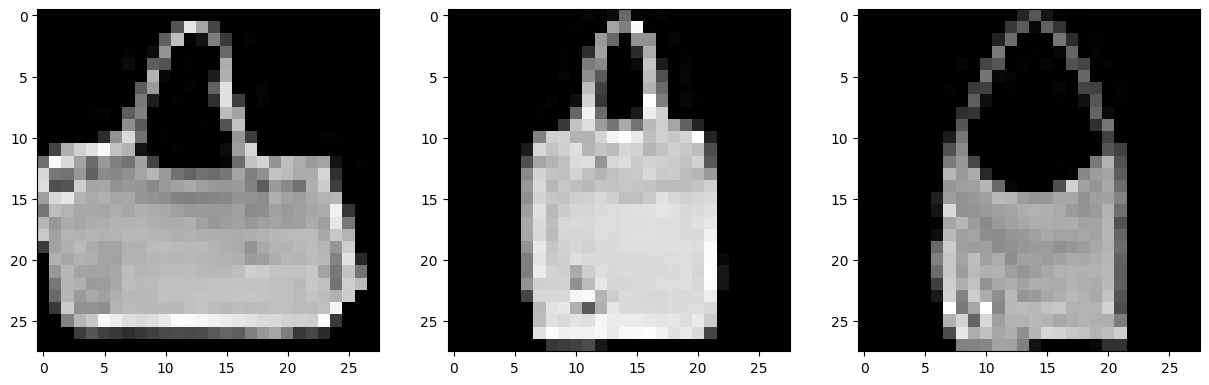

Ankle boot


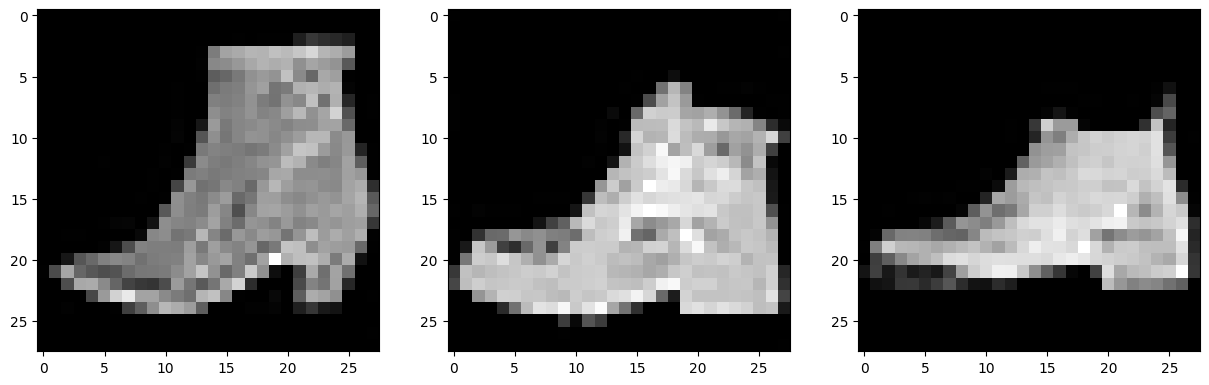

In [15]:
for index in range(len(class_labels)):
    images = []
    for _ in range(3):
        image = generate_image_with_class(model, scheduler, 28, device, index)
        images.append(image)
    print(class_labels[index])
    show_images(images)
